In [28]:
#Libraries
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 13,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

## Calculate the C-bisectors

In [29]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])
# raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

In [30]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [31]:
#Lines from the file of Clean lines
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
613,10425.8870
614,10426.6020
615,10535.1220
616,10580.0390


In [32]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)

closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

In [33]:
# Made a great range
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

#Made a range of 0.2mA for the wavelength
local_points_bis = width_minimums(closer_lines,raw_data,0.2)

In [34]:
def Calculate_bisectors(local_points_bis):
    bisectors = []
    for j in range(0,len(local_points_bis)):
        #Select only the wavelength
        data_bisec = local_points_bis[j]
        minimum = data_bisec[data_bisec['Wave A'] == closer_lines['min_wave'].iloc[j]].index[0]
        list_index = data_bisec.index.values #Take the index for the minimum.

        #Separate in two set around the minimum, a left part and a right
        left = -(min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum
        right = (min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum

        left_data = data_bisec.loc[left:minimum].reset_index(drop=True)
        right_data = data_bisec.loc[minimum:right].sort_values('Wave A', ascending=False).reset_index(drop=True) #arrange the wavelength

        new = pd.concat([(left_data),right_data],axis=1).drop(['Wave (cm)','rFlux'],axis=1)

        new.columns=['L flux', 'L wave','R flux','R wave']

        #The logic is take the midpoint between wavelength at mean fluxes
        distance = (new['R wave'] - new['L wave'])/2 + new['L wave']
        velocity = ((distance/closer_lines['Fe line'].iloc[j]) -1)*const.c #Express it in velocity
        flux = (new['R flux'] - new['L flux'])/2 + new['L flux'] 

        bisectors.append(pd.DataFrame({'Velocity': velocity,'Distance': distance,'Flux': flux}).reset_index(drop=True))

    return bisectors
bisectors = Calculate_bisectors(local_points_bis)

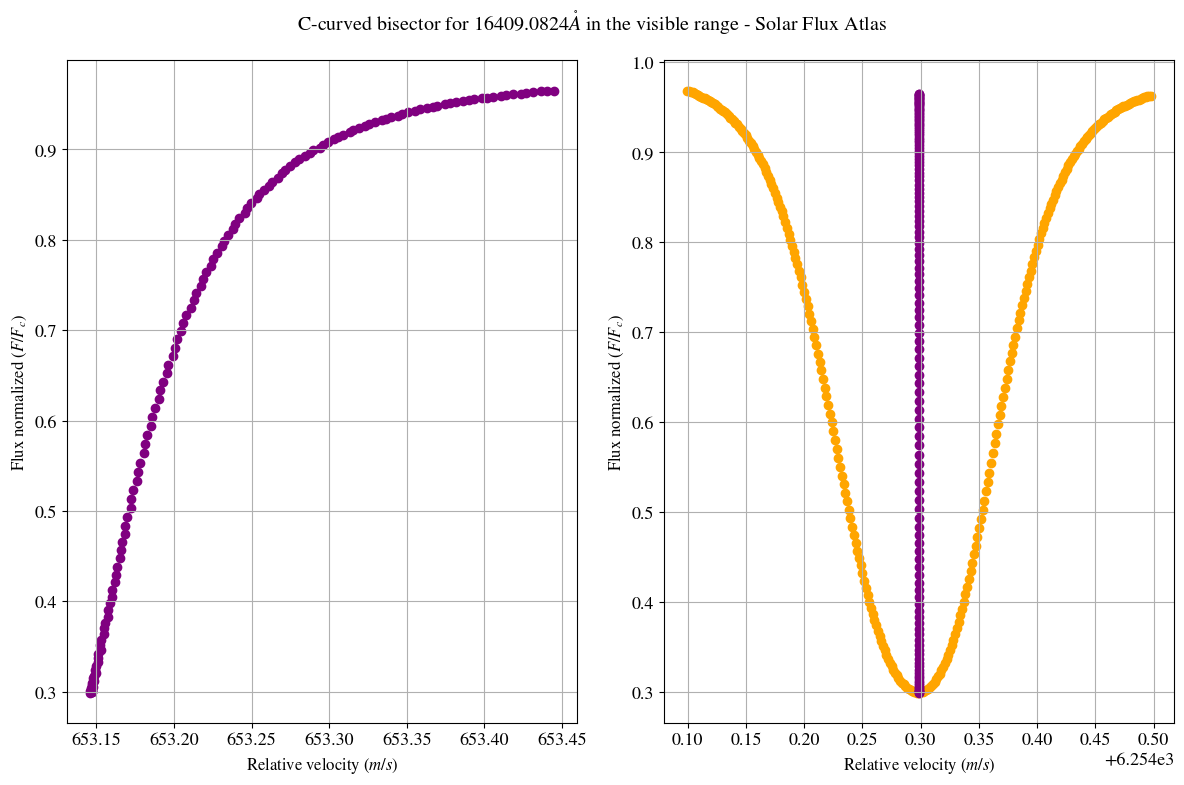

In [35]:
j = 374 #Take an random index

fig1, axis1 = plt.subplots(1,2, figsize = (12,8))
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'C-curved bisector for $16409.0824 \mathring{A}$ in the visible range - Solar Flux Atlas')


ax1.scatter(bisectors[j]['Velocity'],bisectors[j]['Flux'],color='purple')
ax2.scatter(local_points_bis[j]['Wave A'],local_points_bis[j]['nFlux'],color= 'orange')
ax2.scatter(bisectors[j]['Distance'],bisectors[j]['Flux'],color= 'purple')


ax1.grid()
ax1.set_ylabel(r'Flux normalized $(F/F_{c})$')
ax1.set_xlabel(r'Relative velocity $(m/s)$')
ax1.tick_params(axis='both')


ax2.grid()
ax2.set_xlabel(r'Relative velocity $(m/s)$')
ax2.set_ylabel(r'Flux normalized $(F/F_{c})$')
ax2.tick_params(axis='both')

fig1.tight_layout()

# fig1.savefig('C_bisector_individual.pdf')

## Flux deficit

We need to compare results with Gray and Oostra. So, we select the same line 6253 for the flux deficit.

In [55]:
#For this is necessary the standard curve from third signature.

#Just take the values for closer lines and bisector from the line
line_index = closer_lines[closer_lines['Fe line']  == 6254.2850].index[0]
data = bisectors[line_index]

#Parameters from the third signature characterization (Standard curves)
parameters_green = np.array([ 9.58438970e-01, -1.05528079e-03, -3.22527864e-06,  5.13169816e-09]).T
#For a difference between curves we need the same length, remember thats need to be shifted 633m/s
vel_standard = np.linspace(0,630,len(data)) 

#Standard curve with the length of 
flux_standard = poly.polyval(vel_standard,parameters_green)

#Calcule the difference
Flux_deficit = data['Flux'] - flux_standard
Vel_deficit = data['Velocity'] - vel_standard

Deficit = pd.DataFrame({'Flux':Flux_deficit,'Velocity':Vel_deficit })

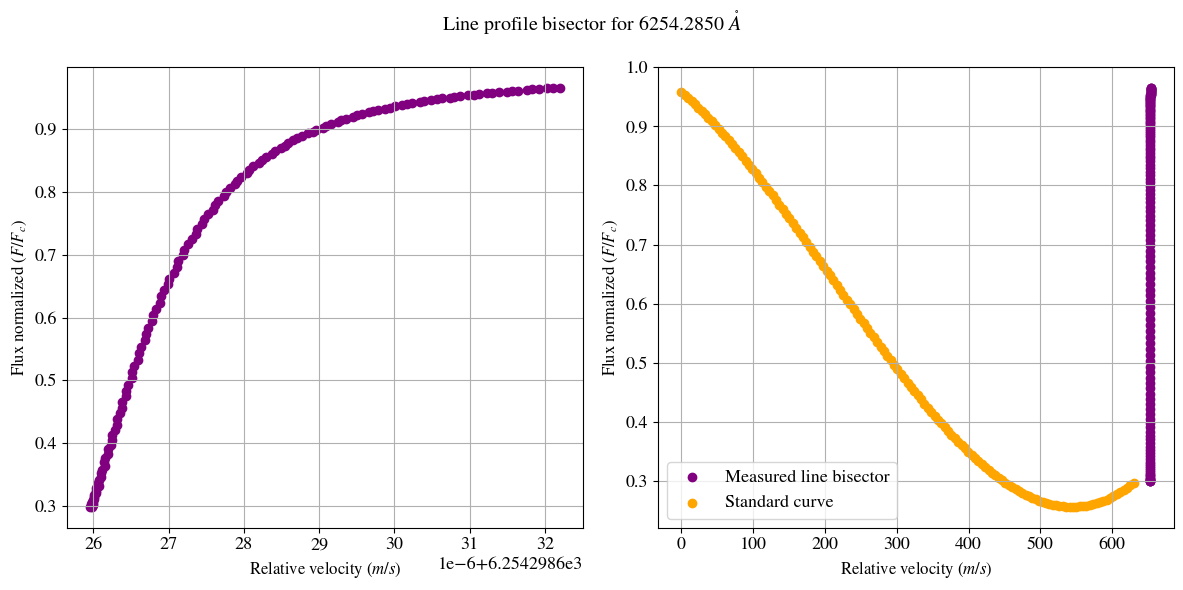

In [56]:
fig2, axis1 = plt.subplots(1,2, figsize = (12,6))
ax1 = axis1[0]
ax2 = axis1[1]

fig2.suptitle(r'Line profile bisector for 6254.2850 $\mathring{A}$')

ax1.scatter(data['Distance'],data['Flux'],color= 'purple',label='Line profile bisector')

ax2.scatter(data['Velocity'],data['Flux'],color= 'purple', label='Measured line bisector')
ax2.scatter(vel_standard,flux_standard,color= 'orange',label='Standard curve')

ax1.grid()
ax1.set_xlabel(r'Relative velocity $(m/s)$')
ax1.set_ylabel(r'Flux normalized $(F/F_{c})$')
ax1.tick_params(axis='both',labelsize=13)

ax2.grid()
ax2.set_xlabel(r'Relative velocity $(m/s)$')
ax2.set_ylabel(r'Flux normalized $(F/F_{c})$')
ax2.legend()
ax2.tick_params(axis='both',labelsize=13)

fig2.tight_layout()

# fig2.savefig('Flux deficit.pdf')

In [57]:
#Point out the mean, maximum, HWM of velocity to the percentil from the line core 
maximum_deficit = Deficit[Deficit['Flux'] == max(Deficit['Flux'])]
maximum_velocity = maximum_deficit['Velocity']
maximum_percentil = 100*( (max(data['Flux'])-min(data['Flux'])) / (maximum_deficit['Flux']-min(data['Flux'])))

mean_deficit = Deficit[Deficit['Flux'] == np.mean(Deficit['Flux'])]
mean_velocity = mean_deficit['Velocity']
mean_percentil = 100*( (max(data['Flux'])-min(data['Flux'])) / (mean_deficit['Flux']-min(data['Flux'])))

index_hwm = round(len(data['Flux'])/2,0)
hwm_deficit = Deficit.loc[index_hwm]
hwm_velocity = hwm_deficit['Velocity']
mean_percentil = 100*( (max(data['Flux'])-min(data['Flux'])) / (hwm_deficit['Flux']-min(data['Flux'])))

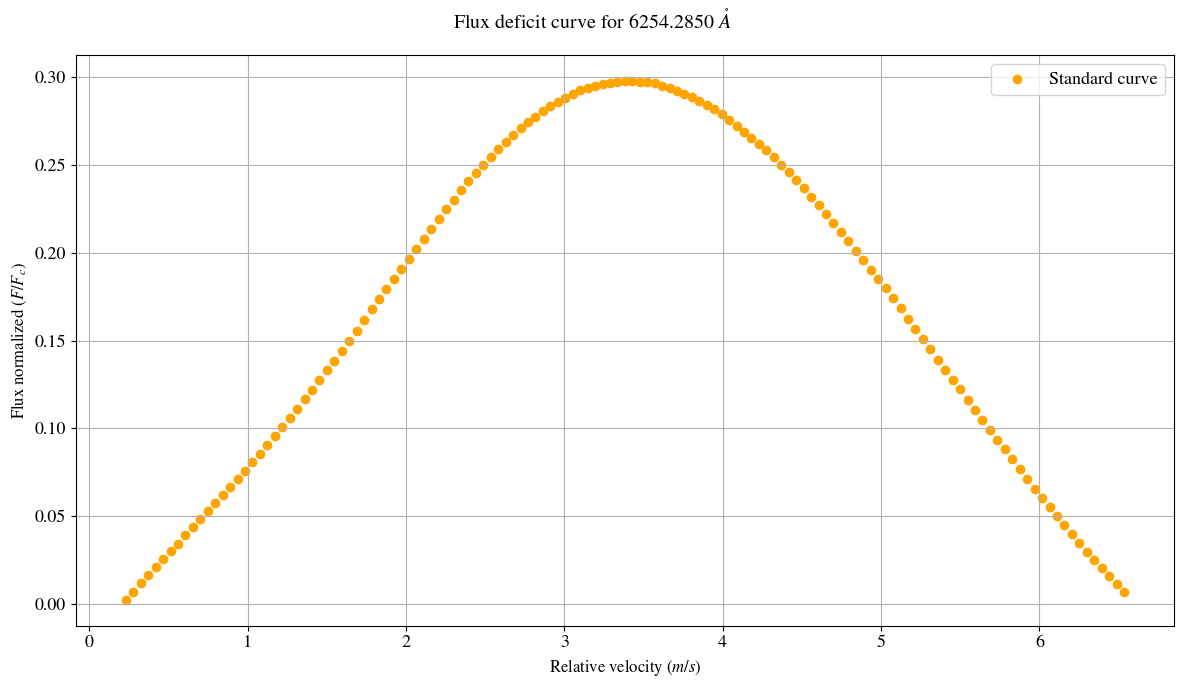

In [61]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

fig3.suptitle(r'Flux deficit curve for 6254.2850 $\mathring{A}$')

ax.scatter(Deficit['Velocity']/100,Deficit['Flux'],color= 'orange',label='Standard curve')
#Points of interest
# ax.scatter(maximum_deficit['Velocity'],maximum_deficit['Flux'],color='red',label='Maximum point')
# ax.scatter(mean_deficit['Velocity'],mean_deficit['Flux'],color='green',label='Mean point')
# ax.scatter(hwm_deficit['Velocity'],hwm_deficit['Flux'],color='blue',label='HWM point')

ax.grid()
ax.legend()
ax.set_xlabel(r'Relative velocity $(m/s)$')
ax.set_ylabel(r'Flux normalized $(F/F_{c})$')

fig3.tight_layout()

# fig3.savefig('Flux deficit curve.pdf')